In [14]:
import numpy as np
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib notebook

mpl.rcParams['axes.spines.top'] = 0
mpl.rcParams['axes.spines.right'] = 0
mpl.rcParams['axes.spines.left'] = 1
mpl.rcParams['axes.spines.bottom'] = 1
mpl.rcParams.update({'font.size': 12})

# Lecture 7: Logistic regression
## Pattern Recognition, Fall 2022

**Ivan Dokmanić**


<img src="figs/sada-unibas-0.svg" width="60%" float="left">


# Recap: three ways to derive optimal linear regressors

We have a dataset $\mathcal{D} = \{ (\mathbf{x}_i, y_i) \}_{i = 1}^n$ and the loss function $\sum_{i=1}^n (y_i - \tilde{\mathbf{x}}_i^T \mathbf{w})^2 = \| \mathbf{y} - \mathbf{X} \mathbf{w} \|^2$

## Algebra

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
solve $\nabla_{\mathbf{w}} \left\| \mathbf{y} - \mathbf{X} \mathbf{w} \right\|^2 = 0$

## Geometry

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
find the vector $\hat{\mathbf{y}} \in \mathrm{span} \{ \mathbf{1}, \mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(d)} \}$ such that $\mathbf{y} - \hat{\mathbf{y}}$ is as short as possible

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
equivalently: find the orthogonal projection of $\mathbf{y}$ onto $\mathrm{span} \{ \mathbf{1}, \mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(d)} \}$

## Probability (with some algebra)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
assume that $p(y \mid \mathbf{x}; \mathbf{w}) \propto \exp \left(-{(y - \mathbf{w}^T \mathbf{x})^2}/{(2\sigma^2)} \right)$ 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
maximize (over $\mathbf{w}$) the likelihood of $\mathcal{D}$

# Recap: linear regression for classification

<IPython.core.display.Javascript object>


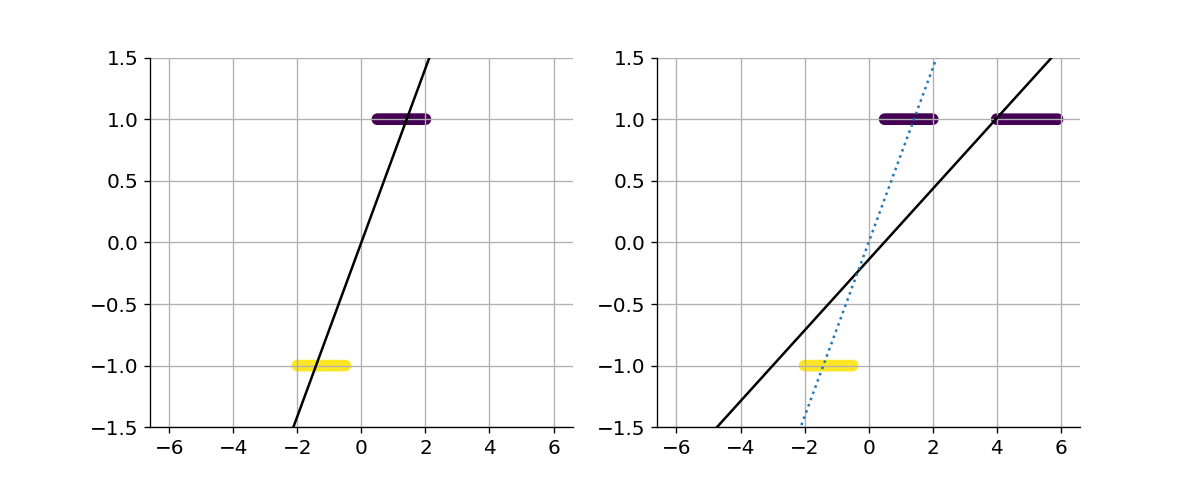

In [3]:
from sklearn.linear_model import LinearRegression

x1 = np.concatenate((np.linspace(-2, -0.5, 20), 
                    np.linspace(0.5, 2, 20))).reshape(-1, 1)

x2 = np.concatenate((np.linspace(-2, -0.5, 20), 
                    np.linspace(0.5, 2, 20),
                    np.linspace(4, 5.9, 20))).reshape(-1, 1)

y1, y2 = np.sign(x1), np.sign(x2)
reg1 = LinearRegression().fit(x1, y1)
reg2 = LinearRegression().fit(x2, y2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(x1, y1, c=-y1)
axs[1].scatter(x2, y2, c=-y2)

x_grid = np.linspace(-6, 6, 200).reshape(-1, 1)
line1, = axs[0].plot(x_grid, reg1.predict(x_grid), 'k')
line2, = axs[1].plot(x_grid, reg2.predict(x_grid), 'k')
line2b, = axs[1].plot(x_grid, reg1.predict(x_grid), ':')
axs[0].grid(True)
axs[1].grid(True)
plt.setp(axs, ylim=(-1.5, 1.5));

# Recap: why does this happen?

- Earlier we used the 0-1 loss to measure quality of classification

$$
    \ell_{01}(y, \hat{y}) = \mathbf{1}(y = \hat{y})
$$
- For labels +1, -1 this can be written 

$$
    \ell_{01}(y, \hat{y}) = 1 - y\hat{y}
$$

- But the output of regression is in $\mathbb{R}$ and not $\in \{1, -1\}$ so this does not make sense

<IPython.core.display.Javascript object>


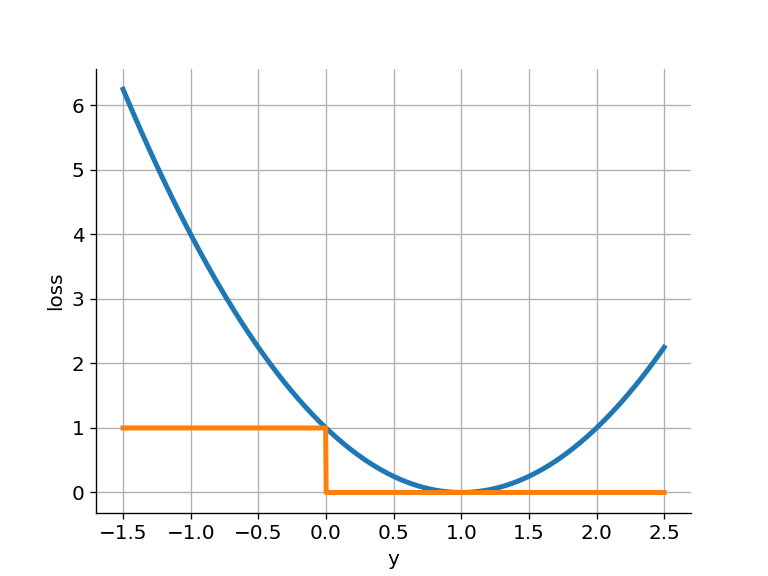

In [4]:
loss_l2 = lambda y, y_hat: (y - y_hat)**2
loss_01 = lambda y, y_hat: (1 - np.sign(y)*y_hat)/2

y = np.linspace(-1.5, 2.5, 1000)
y_hat = 1

fig, ax = plt.subplots(1, 1)
ax.plot(y, loss_l2(y, y_hat), lw=3)
ax.plot(y, loss_01(y, y_hat), lw=3)
plt.setp(ax, xlabel='y', ylabel='loss')
ax.grid(True);

# Plan for today

- understanding how to fix linear regression for classification
    - what we need is _**logistic regression**_

# The problem with least-squares linear regression

- We actually began addressing the problem by looking at the one-hot situation
- The numbers we obtained were not in [0, 1]

In [12]:
from mlxtend.data import loadlocal_mnist

X_train, y_train = loadlocal_mnist(
        images_path='/Users/dokman0000/Downloads/train-images-idx3-ubyte', 
        labels_path='/Users/dokman0000/Downloads/train-labels-idx1-ubyte'
        )

d = 28**2
n = 50000

# sample n digits from the big training set
shuffle_idx = np.random.choice(X_train.shape[0], n)
X_train = X_train[shuffle_idx]
y_train = y_train[shuffle_idx]

# remove pixels that are always zero
nz_mask = np.any(X_train > 0, axis=0)
X_mask = X_train[:, nz_mask] / 255.0
d_mask = nz_mask.sum()

X_b = np.hstack((np.ones((n, 1)), X_mask))

lam = 0.1
y_onehot = np.zeros((n, 10))
for i in range(n):
    y_onehot[i, int(y_train[i])] = 1

W_mask = np.linalg.inv(X_b.T @ X_b + lam * np.eye(d_mask + 1)) @ X_b.T @ y_onehot

In [13]:
with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
    print((X_b @ W_mask)[5])
    print(y_onehot[5])
    print(np.max(X_b @ W_mask))

[ 0.067  0.113 -0.084  0.112 -0.045  0.085 -0.022  0.299 -0.076  0.552]
[ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.000]
1.739216623513491


# Step 1: make sure the numbers are in $[0, 1]$

- Let's do a bit more: let's normalize them so we can interpret as probabilities

$$
    \mathbf{w}_c^T \mathbf{x} \mapsto \frac{g(\mathbf{w}_c^T \mathbf{x})}{\sum_{c' = 1}^C g(\mathbf{w}_{c'}^T \mathbf{x})}
$$

- $g : \mathbb{R} \to [0, 1]$ is _some_ function which squeezes the real line output of regression into $[0, 1]$
- which function to choose? considerations: differentiability, not dividing by zero, expressivity

# Step 1: make sure the numbers are in $[0, 1]$

- A great choice turns out to be the softmax function,

$$
    \mathrm{softmax}(y_1, \ldots, y_C) = 
    \begin{bmatrix}
        \frac{\exp(y_1)}{\sum_{c' = 1}^C \exp(y_c')}\\
        \frac{\exp(y_2)}{\sum_{c' = 1}^C \exp(y_c')}\\
        \vdots\\
        \frac{\exp(y_C)}{\sum_{c' = 1}^C \exp(y_c')}
    \end{bmatrix}
$$


# We still train via least squares... which is silly

- We can now interpret the output as a vector of (posterior) probabilities
- let us then train using some adequate loss, perhaps similar to the 0/1 loss


# Step 2: define posteriors using the new numbers

$$
p(y = c \mid \mathbf{x}; \mathbf{W}) = \frac{\exp(\mathbf{w}_c^T \mathbf{x})}{\sum_{c = 1}^C \exp(\mathbf{w}_{c}^T \mathbf{x})}
$$

Thanks to how we defined the softmax function, this is indeed a well-normalized conditional probability

# Step 3: finding the right weights

How to train given a dataset $\mathcal{D} = \{ (\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n) \}$?

We already know: choose the model parameters which maximize the (log-)likelihood of the data (recall that our dataset is **iid**)

$$
    \ell(\mathbf{W})
    = \log\left( \prod_{i = 1}^n p(y = y_i \mid \mathbf{x}_i ; \mathbf{W}) \right)
    =
    \log\left( \prod_{i = 1}^n
    \frac{\exp(\mathbf{w}_{y_i}^T \mathbf{x}_i)}{\sum_{c = 1}^C \exp(\mathbf{w}_{c}^T \mathbf{x})}
    \right)
$$

This can be simplified by defining some (useful) notation:

$$
    \mu_{ic} = [\mathrm{softmax}(\mathbf{w}_1^T \mathbf{x}_i, \ldots, \mathbf{w}_C^T \mathbf{x}_i)]_c
    \quad\quad
    y_{ic} = \mathbf{1}(y_i = c)
$$

# 

so that the log-likelihood becomes

$$
    \log\left( \prod_{i = 1}^n \prod_{c = 1}^C  \mu_{ic}^{y_{ic}}  \right) = \sum_{i = 1}^n \sum_{c = 1}^C y_{ic} \log \mu_{ic}
$$

For each $i$, $(y_{i1}, \ldots, y_{iC})$ and $(\mu_{i1}, \ldots, \mu_{iC})$ are well-normalized probability distributions over the $C$ classes; the loss function $\sum_{c = 1}^C y_{ic} \log \mu_{ic}$ is the **cross-entropy**

# Two classes

To gain further insight let us consider binary classification. The negative log likelihood simplifies to

$$
\begin{aligned}
    \mathrm{NLL}(\mathbf{w}) 
    &= - \sum_{i = 1}^n \log \left(\mu^{y_{11}} \times (1 - \mu)^{y_{10}}\right) \\
    &= - \sum_{i = 1}^n \big( y_i \log \mu_i + (1 - y_i) \log(1 - \mu_i) \big)
\end{aligned}
$$
where we used the shortcut $\mu_i := \mu_{i1}$ (it follows that $1 - \mu_i = \mu_{i0}$)

Here there are two probability distributions: $(y_i, 1-y_i)$ and $(\mu_i, 1-\mu_i)$ and we are measuring the cross-etropy "distance" between them

# 

Note that we have

$$
\mu_1 = \frac{\exp(\mathbf{w}_{c_1}^T \mathbf{x})}{\exp(\mathbf{w}_{c_1}^T \mathbf{x}) + \exp(\mathbf{w}_{c_1}^T \mathbf{x})} = \frac{1}{1 + \exp((\mathbf{w}_{c_1} - \mathbf{w}_{c_2})^T \mathbf{x})} = \frac{1}{1 + \exp(\mathbf{w}^T \mathbf{x})}
$$

$\Rightarrow$ we can parameterize everything using just one weight vector


For $\mu_{10} = 1 - \mu_1$ we get similarly

$$
1 - \frac{1}{1 + \exp(\mathbf{w}^T \mathbf{x})}
=
\frac{1 + \exp(\mathbf{w}^T \mathbf{x}) - 1}{1 + \exp(\mathbf{w}^T \mathbf{x})}
=
\frac{1}{1 + \exp(-\mathbf{w}^T \mathbf{x})}
$$

NB: The function $x \mapsto 1 / (1 + \exp(-x))$ is known as the _logistic function_ hence the name logistic regression



# 

it is convenient to write this out for labels $y_i \in \{ -1, +1 \}$:

$$
    \mathrm{NLL}(\mathbf{w}) = \sum_{i = 1}^n \log \big( 1 + \exp(-y_i \mathbf{w}^T \mathbf{x}_i) \big)
$$

... and useful and insightful to compare with the least-squares loss

$$
    \mathrm{NLL}_{\ell^2}(\mathbf{w}) 
    = \frac{1}{n} \sum_{i = 1}^n  \big( 1  - y_i \hat{y}_i)^2 \big) 
    = \frac{1}{n} \sum_{i = 1}^n  \big( 1  - y_i \cdot \mathbf{w}^T \mathbf{x}_i)^2 \big) 
$$

# How to find the weights $\mathbf{w}$ 

Compute the derivative and set to zero? Let's try!

$$
    \nabla_{\mathbf{w}} \mathrm{NLL}(\mathbf{w}) = \sum_{i = 1}^n (\mu_i - y_i) \mathbf{x}_i = \mathbf{X}^T (\boldsymbol{\mu} - \mathbf{y})
$$

Alas! The weights are "hidden" in the exponentials within $\boldsymbol{\mu}$!

No nice closed-form expression like for linear regression with the least-squares loss

But no worries at all... we will use optimization!

# Gradient (steepest) descent

A simple idea: gradient is the direction in which the function grows so travel in the opposite direction until you hit some bottom

Initialization: $\mathbf{w}_{(0)}$, stepsize $\eta$

Run the following algorithm for $t = 0, 1, \ldots t_{\text{max}}$:

1. Compute the gradient, $\mathbf{g}_{(t)} = \nabla_{\mathbf{w}} \mathrm{NLL}(\mathbf{w}_{(t)})$
2. Update the weights, $\mathbf{g}_{(t)}$: $\mathbf{w}_{(t+1)} \gets \mathbf{w}_{(t)} - \eta \mathbf{g}_{(t)}$

⚠️ note the minus sign—we are stepping in the direction opposite of gradient

# Example: Aoki function

$$
F(x,y) = 0.5 (x^2 - y)^2 + 0.5 (x-1)^2
$$


<IPython.core.display.Javascript object>


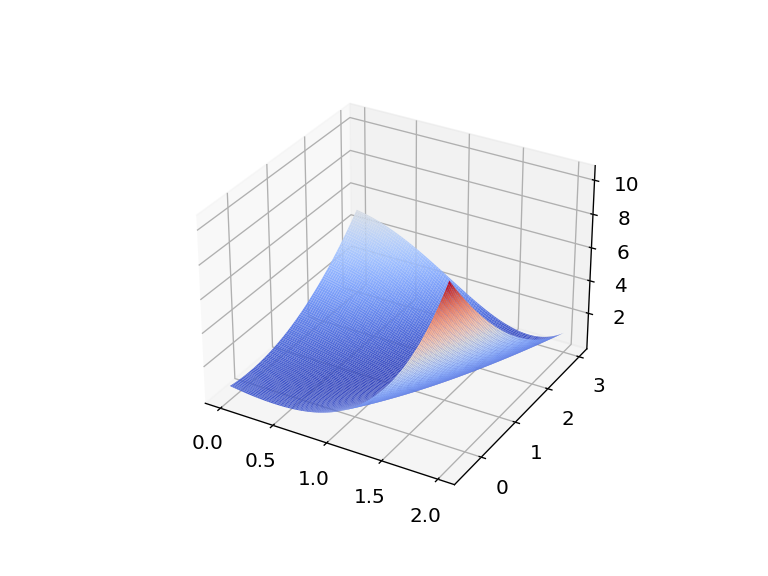

In [16]:
x_ = np.linspace(0, 2, 200)
y_ = np.linspace(-0.5, 3, 200)
xx, yy = np.meshgrid(x_, y_)
zz = 0.5*(xx**2 - yy)**2 + 0.5*(xx - 1)**2

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, zz, cmap=cm.coolwarm,  rcount=100, ccount=100);

In [9]:
step_sizes = [0.3]

<IPython.core.display.Javascript object>


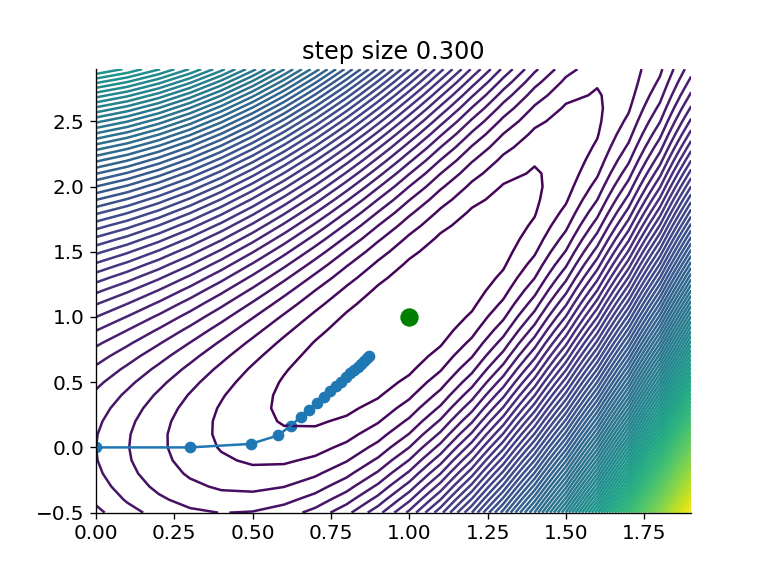

In [11]:
# Author: Meduri Venkata Shivaditya

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, line_search
import time


def aoki_vectorized(x):
    """
    F(x,y) = 0.5 (x^2 - y)^2 + 0.5 (x-1)^2
    """
    f = 0.5 * np.square(np.square(x[:][0]) - x[:][1]) + 0.5 * np.square(x[:][0] - 1)
    return f


def aoki(x):
    """
    F(x,y) = 0.5 (x^2 - y)^2 + 0.5 (x-1)^2
    """
    f = 0.5 * np.square(np.square(x[0]) - x[1]) + 0.5 * np.square(x[0] - 1)
    return f


def aoki_gd(x):
    """
    First-Order derivative of aoki function(Nabia - 1)
    """
    g_x = 2 * np.dot((np.square(x[0]) - x[1]), x[0]) + x[0] - 1
    g_y = -1 * (np.square(x[0]) - x[1])
    return np.array((g_x, g_y))


def aoki_hess(x):
    """
    Second-Order derivative - Hessian Matrix of aoki function(Nabia - 2)
    """
    g_xx = 6 * np.square(x[0]) - 2 * x[1] + 1
    g_xy = -2 * x[0]
    g_yy = 1
    H = np.diag((2, 2))
    H[0][0] = g_xx
    H[0][1] = g_xy
    H[1][0] = g_xy
    H[1][1] = g_yy
    return H


def gradient_descent(x0, f, f_prime, hessian, stepsize=None):
    """
    Steepest-Descent algorithm with option for line search
    """
    x_i, y_i = x0
    all_x_i = list()
    all_y_i = list()
    all_f_i = list()

    for i in range(1, 100):
        all_x_i.append(x_i)
        all_y_i.append(y_i)
        all_f_i.append(f([x_i, y_i]))
        dx_i, dy_i = f_prime(np.asarray([x_i, y_i]))
        if stepsize is None:
            # Compute a step size using a line_search to satisfy the Wolf
            # conditions
            step = line_search(f, f_prime, np.r_[x_i, y_i], -np.r_[dx_i, dy_i], np.r_[dx_i, dy_i], c2=0.05)
            step = step[0]
            if step is None:
                step = 0
        else:
            step = stepsize
        x_i += -step * dx_i
        y_i += -step * dy_i
        if np.abs(all_f_i[-1]) < 1e-16:
            break
    return all_x_i, all_y_i, all_f_i


x1 = np.arange(0, 2, 0.1)
x2 = np.arange(-0.5, 3, 0.1)
x = np.meshgrid(x1, x2)
z = aoki_vectorized(np.array(x))

fig, ax = plt.subplots(1, 1)

nsteps = 20
for i, step in enumerate(step_sizes):
    plt.contour(x1, x2, z, 100)
    plt.plot(1, 1, "go", markersize=10)
    x0 = np.array((0.0, 0.0))
    if step == None:
        xs, ys, fs = gradient_descent(x0, aoki, aoki_gd, hessian=aoki_hess, stepsize=None)
        ttl = "exact line search"
        fname = "steepestDescentDemo_linesearch"
    else:
        xs, ys, fx = gradient_descent(x0, aoki, aoki_gd, hessian=aoki_hess, stepsize=step)
        ttl = "step size {:0.3f}".format(step)
        fname = "steepestDescentDemo_step{:d}".format(int(step * 10))
    ax.scatter(xs[:nsteps], ys[:nsteps])
    ax.plot(xs[:nsteps], ys[:nsteps])
    ax.set_title(ttl);

# Quiz

1. What is the loss for logistic regression?
2. Derive the maximum likelihood estimator in the usual linear regression when $p(y | x; w) \propto \exp(-|y - w^T x|)$
3. Suppose we defined the softmax function with a parameter $\beta$ as
$$
    [\mathrm{softmax}_\beta(y_1, \ldots, y_C)]_{c} = \frac{\exp(\beta y_c)}{\sum_{c' = 1}^C \exp(\beta y_c')}
$$
Compute $\lim_{\beta \to \infty} [\mathrm{softmax}_\beta(y_1, \ldots, y_C)]_{c}$?



# Next time: applying logistic regression to pattern recognition!



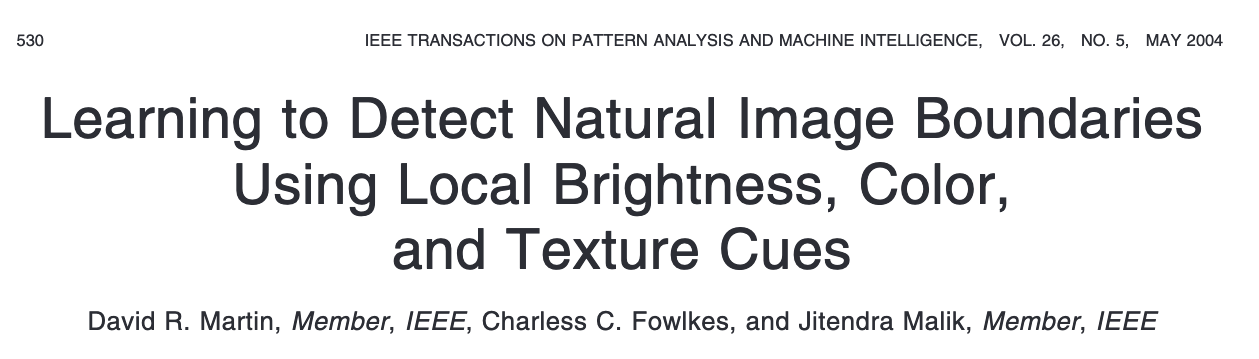